##### **Load packages & data**

In [0]:
# load packages
import io
import ijson
import pandas as pd
import datetime
import nltk
import re
import textblob
import string
import numpy as np
import scipy.spatial.distance as scipydist
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
# from glmnet import glmnet
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from tqdm import tqdm
from tqdm._tqdm import trange
from spellchecker import SpellChecker
from autocorrect import Speller
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mord import LogisticAT
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
import numpy as np

In [0]:
cols = ["reviewerID", "asin", "reviewerName", "helpful_start",
        "helpful_end", "reviewText", "overall", "summary",
        "unixReviewTime", "reviewTime"]

reviewerID = []
asin = []
reviewerName = []
helpful_start = []
helpful_end = []
reviewText = []
overall = []
summary = []
unixReviewTime = []
reviewTime = []
helpful = []

In [0]:
a = datetime.datetime.now()
with open('reviews_electronics.4.json', encoding="UTF-8") as json_file:
    cursor = 0
    for line_number, line in enumerate(json_file):
        #print ("Processing line", line_number + 1,"at cursor index:", cursor)
        line_as_file = io.StringIO(line)
        # Use a new parser for each line
        json_parser = ijson.parse(line_as_file)
        for prefix, type, value in json_parser:
            if (type == 'string') | (type == 'number'):
                if prefix.strip() == 'reviewerID':
                    reviewerID.append(value)
                    #print(value)
                elif prefix.strip() == 'asin':
                    asin.append(value)
                elif prefix.strip() == 'reviewerName':
                    reviewerName.append(value)
                elif prefix.strip() == 'helpful.item':
                    helpful.append(value)
                elif prefix.strip() == 'reviewText':
                    reviewText.append(value)
                elif prefix.strip() == 'overall':
                    overall.append(value)
                elif prefix.strip() == 'summary':
                    summary.append(value)
                elif prefix.strip() == 'unixReviewTime':
                    unixReviewTime.append(value)
                elif prefix.strip() == 'reviewTime':
                    reviewTime.append(value)
        cursor += len(line)

        
b = datetime.datetime.now()
       
helpful_start = [helpful[i] for i in range(len(helpful)) if i%2 == 0]
helpful_end = [helpful[i] for i in range(len(helpful)) if i%2 == 1]

review = pd.DataFrame(list(zip(reviewerID, asin, reviewerName, helpful_start, helpful_end,
                           reviewText, overall, summary, unixReviewTime, reviewTime)),
               columns =cols)
c=b-a
print(c.seconds)

In [0]:
reviews = review.copy()

In [0]:
reviews.head()

,reviewerID,asin,reviewerName,helpful_start,helpful_end,reviewText,overall,summary,unixReviewTime,reviewTime
0,AKM1MP6P0OYPR,0132793040,"Vicki Gibson ""momo4""",1,1,Corey Barker does a great job of explaining Bl...,5.0,Very thorough,1365811200,"04 13, 2013"
1,A22X9YQ3YPRUIJ,B000WW1YVU,T. Nelson,4,4,I live in L.A./Orange County CA area with LOTS...,2.0,Power Boost for Belkin TuneBase FM With Clears...,1202428800,"02 8, 2008"
2,A2T0MTHNOFBPQ,B000WW1YVU,Tomy,1,3,I bought this product (I did not buy from amaz...,1.0,I do not recommend to buy this product.,1270425600,"04 5, 2010"
3,A3QS4VQPONP1RZ,B000WW1YVU,Tricia,0,0,For years I had a cheaper Belkin TuneBase tran...,3.0,Pricier but not better,1390176000,"01 20, 2014"
4,AQFDX78HMJ6DU,B000WW1YVU,TWC42,2,2,There are no clear areas on the FM dial in the...,1.0,No clear channel in DC Metro area,1239321600,"04 10, 2009"


##### **1. Lower Case & Stopwords**

Treat each review as a document. Ignore misspellings. Convert all reviews to lower case. Remove stop words (use package to do this).

In [0]:
# lower case
reviews["reviewText"] = reviews["reviewText"].apply(str.lower)

We are using NLTK's stopwords library. We have added an additional step - remove stopwords "not" and "_n't". This is to ensure, we are not excluding these words from our final review text.

In [0]:
# load stopwords
nltk.download('stopwords')
stops = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\boyas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
rx_not = re.compile(r'not')
rx_nt = re.compile(r"[a-z]+n't")
stops = [i for i in stops if not rx_not.match(i) and not rx_nt.match(i)]
stops = set(stops)

In [0]:
# remove stopwords
reviews["reviewText"] = reviews["reviewText"].apply(lambda x: ' '.join([item for item in x.split() if item not in stops]))

##### **2. Negations**

Handle negation: Look for the following two negations: "not" and "xxxn't" (e.g., don't, didn't etc.). Split off the "n't" part from "xxxn't" into separate words "xxx" and "not". Attach all 'not's (any normal "not" appearing in the text as well as the "n't" converted to "not") to the subsequent word, eg "not_nextword" (code this yourself).

In [0]:
# handle negative words
reviews["reviewText"] = reviews["reviewText"].apply(lambda x: re.sub(r"(not)(\s)(\w+)",r"not_\3",str(x)))
reviews["reviewText"] = reviews["reviewText"].apply(lambda x: re.sub(r"(\s)([a-z]*)(n't)(\s)(\w+)",r"\1not_\5",str(x)))

In [0]:
reviews["reviewText"][8]

'so, use charge ipod car fm transmission horrible distracting frustrating listen driving. open remove inductor see get better fm signal.now tried fm transmitter, not_think ever good enough frustration free long distance driving ipod listening. best thing aux line, 2006 corolla not_one. time new car. ha!'

##### **3. Stem**

Stem all words using Porter 1979 (use package to do this).

In [0]:
ps = PorterStemmer() 

In [0]:
# stem words
reviews["reviewText"] = reviews["reviewText"].apply(lambda x: ' '.join([ps.stem(item) for item in x.split()]))

In [0]:
reviews["reviewText"][0]

'corey barker great job explain blend mode dvd. kelbi train video great pricey buy individually. realli want bang buck subscrib kelbi train online.'

##### **4. Frequency count**

Create frequency count table for all word stems in all reviews (this will be big). Use the most frequent 500 words to define the word vector. Create a bag-of-word vector representation for each review in electronics

In [0]:
# tokenize
reviews["reviewText"] = reviews["reviewText"].apply(lambda x: nltk.word_tokenize(x))

In [0]:
# remove apostrophes
reviews["reviewText"] = reviews["reviewText"].apply(lambda x: " ".join([word.strip(string.punctuation) for word in x]))

In [0]:
# concat all words in all reviews
words = reviews["reviewText"].str.cat(sep=' ')

In [0]:
reviews["reviewText"]

0         corey barker great job explain blend mode dvd ...
1         live l.a./orang counti ca area lot fm radio si...
2         bought product  i not_buy amazon  disappointed...
3         year cheaper belkin tunebas transmitt old mini...
4         clear area fm dial md/dc area product work wit...
5         got last night  monday novemb 4th  2007  2:00a...
6         devic work well easi operate  wife love it  re...
7         least factori fm receiv honda accord  tunebas ...
8         so  use charg ipod car fm transmiss horribl di...
9         product work expect box  however  recept terri...
10        five star product  replac first tuner short co...
11        would not_recommend product anybody  constantl...
12        virtual everi product line come market least o...
13        product terrible  alreadi return origin unit b...
14        disappoint product received  complet fell apar...
15        advertised  hold wire place way activities  cl...
16        i  v tri sever differ type cab

In [0]:
# frequency count
word_dist = nltk.FreqDist(words.split())

In [0]:
# most frequent 500 words
most_freq = dict(word_dist.most_common(500))

In [0]:
most_freq

{'use': 282651,
 'work': 215975,
 'one': 198732,
 'great': 182637,
 'i': 177194,
 'would': 150331,
 'get': 148237,
 'good': 143308,
 'it': 133868,
 'like': 130561,
 'product': 125235,
 'camera': 113605,
 'sound': 113519,
 'time': 109335,
 'well': 106213,
 'price': 100522,
 'tv': 97198,
 'look': 92591,
 'need': 88913,
 'bought': 88601,
 'also': 82412,
 'cabl': 80112,
 'buy': 79742,
 'qualiti': 76401,
 'set': 72217,
 'make': 70408,
 'm': 70104,
 'easi': 68997,
 'purchas': 68854,
 'go': 68065,
 'much': 67931,
 'realli': 67758,
 'want': 67619,
 'unit': 67134,
 'littl': 66933,
 'batteri': 66434,
 'even': 65415,
 'better': 64344,
 'problem': 63666,
 'drive': 63279,
 'v': 62964,
 'back': 62892,
 'got': 61857,
 'thing': 61599,
 'could': 59574,
 'take': 59056,
 'new': 58732,
 'still': 58229,
 'case': 57403,
 'pictur': 55923,
 'tri': 55918,
 'first': 55344,
 'two': 54217,
 'recommend': 53077,
 'power': 52656,
 'nice': 52112,
 '2': 51718,
 'love': 51233,
 'card': 48928,
 'connect': 48837,
 'scree

In [0]:
# bag-of-word vector
vectorizer = CountVectorizer(most_freq, max_features = 500)
bow_vector = vectorizer.fit_transform(reviews["reviewText"]).toarray()

##### **5. Distance**

Establish a method for measuring the distance between different reviews. Print the mutual distance between the first 100 reviews (review IDs) to screen, sorted from closest to furthest.

*We are using Euclidean distance between individual review's bag of words vector, where every element is 1 or 0 (if most frequent word is present in that review or not).*

In [0]:
first_100 = pd.DataFrame(bow_vector).loc[0:99]
dist_euclid = scipydist.pdist(first_100, metric='euclidean')

In [0]:
dist_euclid= np.sort(dist_euclid)

In [0]:
dist_euclid_df = pd.DataFrame(scipydist.squareform(dist_euclid))

In [0]:
dist_euclid_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,2.449490,2.449490,2.645751,2.645751,2.645751,2.828427,3.000000,3.000000,3.000000,...,3.464102,3.464102,3.464102,3.464102,3.464102,3.464102,3.464102,3.464102,3.464102,3.464102
1,2.449490,0.000000,3.464102,3.464102,3.464102,3.464102,3.464102,3.464102,3.464102,3.605551,...,3.741657,3.741657,3.741657,3.741657,3.741657,3.741657,3.741657,3.741657,3.741657,3.741657
2,2.449490,3.464102,0.000000,3.741657,3.741657,3.741657,3.741657,3.741657,3.741657,3.741657,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
3,2.645751,3.464102,3.741657,0.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.242641,4.242641,4.242641,4.242641,4.242641,4.242641,4.242641,4.242641,4.242641,4.242641
4,2.645751,3.464102,3.741657,4.000000,0.000000,4.242641,4.242641,4.242641,4.242641,4.242641,...,4.358899,4.358899,4.358899,4.358899,4.358899,4.358899,4.358899,4.358899,4.358899,4.358899
5,2.645751,3.464102,3.741657,4.000000,4.242641,0.000000,4.472136,4.472136,4.472136,4.472136,...,4.582576,4.582576,4.582576,4.582576,4.582576,4.582576,4.690416,4.690416,4.690416,4.690416
6,2.828427,3.464102,3.741657,4.000000,4.242641,4.472136,0.000000,4.690416,4.690416,4.690416,...,4.795832,4.795832,4.795832,4.795832,4.795832,4.795832,4.795832,4.795832,4.795832,4.795832
7,3.000000,3.464102,3.741657,4.000000,4.242641,4.472136,4.690416,0.000000,4.795832,4.795832,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
8,3.000000,3.464102,3.741657,4.000000,4.242641,4.472136,4.690416,4.795832,0.000000,5.000000,...,5.196152,5.196152,5.196152,5.196152,5.196152,5.196152,5.196152,5.196152,5.196152,5.196152
9,3.000000,3.605551,3.741657,4.000000,4.242641,4.472136,4.690416,4.795832,5.000000,0.000000,...,5.385165,5.385165,5.385165,5.385165,5.385165,5.385165,5.385165,5.385165,5.385165,5.385165


##### **6. PCA**

Run a PCA and graph the first two PCs for the first 100 reviews.Does your graph reflect your findings from the previous exercise?

In [0]:
x = StandardScaler().fit_transform(first_100)

In [0]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

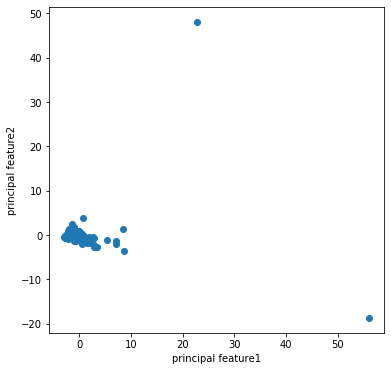

In [0]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

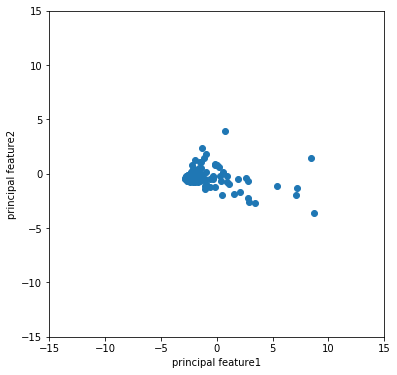

In [0]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.ylim(-15,15)
plt.xlim(-15,15)
plt.show();

From the graph , we see most of the points have PCA 1 , 2 ranging from -5 to 5. 

##### **7**.
Is it possible to use logistic regression to predict the rating (5 levels) of a product?Why may it be advantageous to use a logistic regression to predict the 5-star rating over MNL with 5 categories?

*Yes. We can use logistics regression to predict the rating of a product because it is an ordinal variable. This is better than MNL to predict the 5 star rating,as MNL loses the preference information while classifying - Eg. a 5 star is better than a 3 star*

##### **8**.
Perform a lasso logistic regression and measure the out-of-sample accuracy of your method of choice.

In [0]:
y = reviews["overall"].astype(int)
x_bow = StandardScaler().fit_transform(pd.DataFrame(bow_vector))
x_bow = pd.DataFrame(x_bow)

In [0]:
ordlogit_lasso = LogisticAT(alpha=1)

In [0]:
x_bow_train,x_bow_test,y_train,y_test=train_test_split(x_bow, y, test_size=0.9, random_state=31)
ordlogit_lasso.fit(x_bow_train, y_train)
ordlogit_lasso_predictions = ordlogit_lasso.predict(x_bow_test)
accuracy = accuracy_score(y_test, ordlogit_lasso_predictions)
print('Ordered logistic regression: ', accuracy)

Ordered logistic regression:  0.5224391822644155


In [0]:
acc = make_scorer(accuracy_score)
accuracy_cv = cross_val_score(ordlogit_lasso, x_bow, y, cv = 3, scoring=acc)
print('Ordered logistic regression (3-fold cv): ', np.mean(accuracy_cv))

Ordered logistic regression:  0.5220936418453274


In [0]:
# UNABLE TO RUN ON WINDOES SYSTEM
# x_bow = StandardScaler().fit_transform(pd.DataFrame(bow_vector))

# y_overall = reviews["overall"].apply(lambda x: (x-1)/4).astype(float)
# y_overall = np.array(y_overall)

# cvfit = cvglmnet(x = x_bow, y = y_overall, family = 'binomial', ptype = 'class', nfolds = 5)

Thus OOS accuracy for logistic model = **52%**

##### **9**. 
Implement a method to aggregate reviews by product. Can you use anyof the other columns to help with aggregation?Explain why or why not.Please clearly explain your method.

*We are aggregating reviews by product id.Also, we have filtered out reviews with 0 helpful score*


In [0]:
# aggregate reviews by product using all reviews
reviews_bow = pd.concat([reviews.reset_index(drop=True), pd.DataFrame(bow_vector)], axis=1)
aggregate_reviews = reviews_bow.groupby('asin')[np.arange(0,500)].sum()
aggregate_reviews

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
asin,,,,,,,,,,,,,,,,,,,,,
0132793040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B000WW1YVU,0,0,0,0,0,0,0,2,0,0,...,1,11,0,2,0,2,0,0,1,0
B000WW1YW4,1,0,0,0,0,0,0,2,0,0,...,0,1,0,4,0,0,0,0,0,0
B000WW3TLI,0,0,1,1,0,4,1,0,0,2,...,1,20,2,6,2,1,0,0,1,0
B000WW3TM2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
B000WWBL36,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
B000WWGS66,0,0,0,0,0,2,1,0,0,0,...,0,3,0,1,1,0,0,0,0,0
B000WWIU26,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
B000WWJLH4,3,0,1,2,1,0,1,4,0,5,...,6,54,1,28,5,3,2,1,1,0


In [0]:
# Use other columns to help with aggregation
# Drop reviews with helpfulness score == 0,
# which means no one finds this review is helpful
# define helpful reviews as reviews which at least 1 person find helpful
reviews_bow['helpfulness'] = reviews_bow["helpful_start"]/reviews_bow["helpful_end"]
reviews_bow["helpfulness"] = reviews_bow["helpfulness"].fillna(0)
reviews_bow_helpful = reviews_bow[reviews_bow["helpfulness"]>0]
aggregate_reviews_helpful = reviews_bow_helpful.groupby('asin')[np.arange(0,500)].sum()
aggregate_reviews_helpful

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
asin,,,,,,,,,,,,,,,,,,,,,
0132793040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B000WW1YVU,0,0,0,0,0,0,0,1,0,0,...,1,6,0,1,0,1,0,0,1,0
B000WW1YW4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
B000WW3TLI,0,0,1,0,0,0,1,0,0,1,...,1,10,1,2,2,0,0,0,0,0
B000WW3TM2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
B000WWIU26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
B000WWJLH4,2,0,1,1,1,0,0,1,0,3,...,1,13,1,13,2,3,0,0,1,0
B000WWK16O,2,3,5,4,2,1,0,3,0,0,...,1,17,0,22,0,2,0,0,1,0
B000WWKM2M,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0


##### **10.**
Establish a method for measuring the distance between different products.

*We have used euclidean distances betweem aggregated products *

In [0]:
# measure the distance between products using all reviews
product_dist = scipydist.pdist(aggregate_reviews, metric='euclidean')
product_dist_squareform = scipydist.squareform(product_dist)
product_dist_squareform_df = pd.DataFrame(product_dist_squareform)
product_dist_squareform_df 

In [0]:
# measure the distance between products using helpful reviews only
product_dist_helpful = scipydist.pdist(aggregate_reviews_helpful, metric='euclidean')
product_dist_squareform_helpful = scipydist.squareform(product_dist_helpful)
product_dist_squareform_df_helpful = pd.DataFrame(product_dist_squareform_helpful)
product_dist_squareform_df_helpful

,0,1,2,3,4,5,6,7,8,9,...,16928,16929,16930,16931,16932,16933,16934,16935,16936,16937
0,0.000000,39.230090,8.426150,48.445846,9.000000,6.164414,66.520673,157.730783,13.152946,28.705400,...,231.706711,10.049876,10.816654,4.690416,7.483315,11.832160,15.588457,5.656854,4.123106,1964.824929
1,39.230090,0.000000,37.416574,48.846699,37.868192,39.382737,54.092513,153.264477,39.673669,43.116122,...,224.336800,38.626416,38.729833,39.281039,39.127995,38.820098,39.623226,39.179076,39.268308,1946.929891
2,8.426150,37.416574,0.000000,47.138095,10.862780,9.433981,64.482556,156.729066,14.352700,28.583212,...,230.709774,12.000000,12.649111,8.185353,10.049876,13.527749,16.733201,8.544004,8.124038,1962.436241
3,48.445846,48.846699,47.138095,0.000000,46.043458,48.672374,58.991525,147.322775,47.853944,48.569538,...,219.601913,46.840154,46.626173,48.487112,47.549974,48.114447,48.083261,48.238988,48.662100,1942.310480
4,9.000000,37.868192,10.862780,46.043458,0.000000,9.949874,64.342832,156.364958,14.212670,27.694765,...,229.662796,11.916375,11.045361,9.110434,10.246951,13.820275,17.029386,9.000000,8.944272,1962.466815
5,6.164414,39.382737,9.433981,48.672374,9.949874,0.000000,66.790718,158.091746,13.820275,29.393877,...,231.948270,10.816654,11.090537,6.164414,7.745967,12.569805,16.583124,6.928203,5.744563,1965.185233
6,66.520673,54.092513,64.482556,58.991525,64.342832,66.790718,0.000000,150.199867,65.757129,64.366140,...,217.740671,64.358372,65.467549,66.430415,65.551506,65.490457,65.482822,66.385239,66.648331,1932.385055
7,157.730783,153.264477,156.729066,147.322775,156.364958,158.091746,150.199867,0.000000,156.492811,153.352535,...,243.320776,156.882121,156.531147,157.800507,157.426173,155.232084,156.595019,157.857531,157.949359,1921.587885
8,13.152946,39.673669,14.352700,47.853944,14.212670,13.820275,65.757129,156.492811,0.000000,27.073973,...,229.519062,15.297059,15.297059,13.152946,14.035669,16.278821,19.235384,13.304135,12.884099,1962.598278
9,28.705400,43.116122,28.583212,48.569538,27.694765,29.393877,64.366140,153.352535,27.073973,0.000000,...,225.933619,29.103264,28.827071,28.982753,29.154759,29.832868,30.935417,29.154759,28.965497,1956.002301
